# Goal:

We want to build a character-based recurrent autoencoder (using attention and lstm recurrent units)

In [56]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import pandas as pd
import unicodedata
import string
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam

In [57]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9254018276178909113
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10642364982528568774
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10669107456
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12242065144125447365
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17286600213883837480
physical_device_desc: "device: XLA_GPU device"
]


## Load dataset

In [58]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.text = df.text.str.replace('\s+', ' ')

In [59]:
df = pd.read_csv('../dataset/movies_complete.csv')
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [60]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) +1 # for unknown token

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [61]:
texts = df.text.apply(unicodeToAscii).to_list()

# Preprocessing (Keras)

In [62]:
num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1


In [63]:
#matrix = tk.texts_to_matrix(texts, mode='binary')

In [64]:
#sequences

In [65]:
maxlen = 500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [66]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [67]:
X.shape, X.nbytes * 1e6

((3486, 500, 1000), 1743000000000000.0)

In [68]:
#matrix = matrix.astype('int8')

## Define model

#### Dense Model

In [69]:
def build_dense(num_words):
    
    stacked_encoder = Sequential([
        Input(shape=(num_words)),
        Dense(256, activation="linear"),
        Dense(128, activation="linear"),
    ])
    
    stacked_decoder = Sequential([
        Dense(128, activation='linear', input_shape=[128]),
        Dense(256, activation="linear"),
        Dense(num_words, activation="sigmoid")
    ])
    stacked_ae = Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss="binary_crossentropy",
    optimizer=Adam(lr=0.01))
    return stacked_ae, stacked_encoder
 

In [70]:
#autoencoder, encoder = build_dense(num_words)
#autoencoder.summary()

In [71]:
#autoencoder.fit(matrix, matrix, epochs=10, batch_size=128)

In [72]:
#embedding = encoder.predict(matrix)
#embedding

In [73]:
#from umap import UMAP
#import seaborn as sns

#umap = UMAP(n_components=2)
#red = umap.fit_transform(embedding)

#sns.scatterplot(x=embedding[:,0], y=embedding[:,1])


In [74]:
#from sklearn.decomposition import PCA
#p = PCA(n_components=2).fit_transform(matrix)
#sns.scatterplot(x=p[:,0], y=p[:,1])



#### Recurrent-Model

In [269]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

def build_recurrent_model(n_letters, maxlen):
    encoder = Sequential([
        Input(shape=(maxlen)),
        Embedding(n_letters, 32),
        LSTM(32,
             return_sequences=True,
            ),
        LSTM(16,
             return_sequences=False,
            ),
    ])
    decoder = Sequential([
        RepeatVector(maxlen),
        LSTM(16,
             return_sequences=True,
            ),
        TimeDistributed(Dense(n_letters, activation='sigmoid'))
    ])
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(loss='mse', optimizer='rmsprop')
    return autoencoder, encoder

In [270]:
callbacks = [
    ModelCheckpoint(filepath='../Results/autoencoder/model.{epoch:02d}-{loss:.2f}.h5',
                    monitor='loss',
                    save_best_only=True,
                    save_freq=5),
    TensorBoard(log_dir='../Results/tensorboard_logs',
                embeddings_freq=1)
]

In [271]:
recurrent_autoencoder, recurrent_encoder = build_recurrent_model(num_words, maxlen)
recurrent_autoencoder.summary()
recurrent_encoder.summary()

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_123 (Sequential)  (None, 16)                43456     
_________________________________________________________________
sequential_124 (Sequential)  (None, 500, 1000)         19112     
Total params: 62,568
Trainable params: 62,568
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 500, 32)           32000     
_________________________________________________________________
lstm_138 (LSTM)              (None, 500, 32)           8320      
_________________________________________________________________
lstm_139 (LSTM)              (None, 16)                3136      
Total params: 43,456
Tra

In [272]:
#X = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))

history = recurrent_autoencoder.fit(sequences, X, batch_size=64, epochs=10, callbacks=callbacks)

Epoch 1/10
55/55 [==============================] - 6s 109ms/step - loss: 0.1394
Epoch 2/10
55/55 [==============================] - 6s 106ms/step - loss: 0.0370
Epoch 3/10
55/55 [==============================] - 6s 103ms/step - loss: 0.0104
Epoch 4/10
55/55 [==============================] - 6s 104ms/step - loss: 0.0034
Epoch 5/10
55/55 [==============================] - 6s 103ms/step - loss: 0.0016
Epoch 6/10
55/55 [==============================] - 6s 107ms/step - loss: 0.0011
Epoch 7/10
55/55 [==============================] - 6s 106ms/step - loss: 0.0010
Epoch 8/10
55/55 [==============================] - 6s 106ms/step - loss: 9.7316e-04
Epoch 9/10
55/55 [==============================] - 6s 106ms/step - loss: 9.6193e-04
Epoch 10/10
55/55 [==============================] - 6s 103ms/step - loss: 9.5704e-04


In [273]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)
    

(3486, 16)


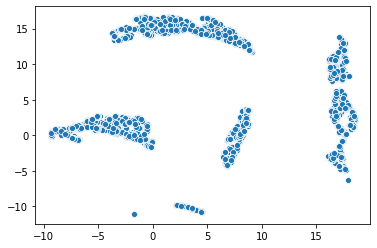

In [275]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns

r = UMAP(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1])


In [267]:
embeddings.std(axis=0)

array([0.00176746, 0.00115438, 0.0010179 , 0.00161795, 0.00117639,
       0.00141092, 0.00196444, 0.00128726, 0.00089788, 0.00153283,
       0.00134713, 0.00146617, 0.00156416, 0.00141829, 0.00086987,
       0.00208476], dtype=float32)

In [268]:
embeddings

array([[-0.99028045,  0.9936927 , -0.9953435 , ..., -0.9929583 ,
         0.9955513 , -0.9883416 ],
       [-0.98883736,  0.99277836, -0.9945461 , ..., -0.99183285,
         0.9948371 , -0.98656416],
       [-0.98923457,  0.99309736, -0.99477327, ..., -0.99218154,
         0.9950296 , -0.9871584 ],
       ...,
       [-0.99011564,  0.993469  , -0.9952501 , ..., -0.99276274,
         0.9954412 , -0.9880993 ],
       [-0.9887428 ,  0.9927307 , -0.994515  , ..., -0.9918071 ,
         0.99479353, -0.9865707 ],
       [-0.98984444,  0.99330693, -0.9951248 , ..., -0.9925674 ,
         0.99532074, -0.9877741 ]], dtype=float32)